In [1]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation


Dx= 20
Lx= 3000
Dy= Dx
Ly= Lx
U= 0
V= 0
g= 9.8
H= 5
h_mtn = 0.25
w_xmtn = 100
w_ymtn = w_xmtn
x_0 = Lx/2
y_0 = Ly/2
T=400
K=25
coriolis_parameter = 5e-2
Nx = int(Lx/Dx)
Ny = int(Ly/Dy)

Dt = 0.5
n_plot = 1 

Diffusivity = "True" # Options: "True" or "False"
Nonlinear = "False" # If True, non-linear advection added
Coriolis = "False"
topography = "Water_Pile" 
plot_type = "Contour"
Balanced = "False"
Restoring = "False"
Random_Noise = "False"
Boundary_Condition = "Coasts"

restoring_rate = 1
    
n_plot = 1 

if Boundary_Condition == "Coasts": # Set normal velocities to zero at boundaries
    T=800

n_timesteps = T/Dt + 1

# Create grid
x_1D = np.arange(0,Lx,Dx)
y_1D = np.arange(0,Ly,Dy)

# Set initial condition
u = np.zeros([Nx, Ny, int(n_timesteps)])
v = np.zeros([Nx, Ny, int(n_timesteps)])
h = np.zeros([Nx, Ny, int(n_timesteps)])
h_s = np.zeros([Nx, Ny])
x = np.zeros([Nx, Ny])
y = np.zeros([Nx, Ny])
for y_step in range(Ny):
    x[:,y_step] = x_1D
for x_step in range(Nx):
    y[x_step,:] = y_1D
    
# Apply initial condition
u[:,:,0]=U
h[:,:,0]=H
v[:,:,0]=V

# Create seamount (note h-points are located Dx/2 ahead of u-points)
if topography == "Ridge":
    h_s = h_mtn*np.exp(- 0.5 * (x -x_0)**2. / w_xmtn**2 )
elif topography == "Mount":
    h_s = h_mtn*np.exp(- 0.5 *( ( (x -x_0)**2. / w_xmtn**2 ) + (y - y_0)**2. / w_ymtn**2 ) )
elif topography == "Partial_Ridge":
    h_s = h_mtn*np.exp(- 0.5 * (x -x_0)**2. / w_xmtn**2 ) *(1- np.exp(- 0.5 * (y -y_0)**2. / w_ymtn**2 ))
elif topography == "Water_Pile": # Change surface height instead of bathymetry and start with no mean motion
    h[:,:,0] = h_mtn*np.exp(- 0.5 *( ( (x -x_0)**2. / w_xmtn**2 ) + (y - y_0)**2. / w_ymtn**2 ) )
elif topography == "Water_Ridge": # Change surface height instead of bathymetry and start with no mean motion
    h[:,:,0] = h_mtn*np.exp(- 0.5 * (x -x_0)**2. / w_xmtn**2 )
    
if Random_Noise == "True":
    random_array = 0.01*np.random.rand(Nx, Ny)*h_mtn
    h[:,:,0] += random_array
    
    
if Balanced == "True":
    v[:,:,0]=(g/coriolis_parameter)*0.5*( ( np.roll(h[:,:,0],-1,0) + np.roll(h[:,:,0],(-1,1),(0,1)) ) - 
                                           (np.roll(h[:,:,0],1,0) + np.roll(h[:,:,0],(1,1),(0,1)) ) )/(2*Dx)
    u[:,:,0]=-(g/coriolis_parameter)*0.5*( ( np.roll(h[:,:,0],-1,1) + np.roll(h[:,:,0],(1,-1),(0,1)) ) - 
                                           (np.roll(h[:,:,0],1,1) + np.roll(h[:,:,0],(1,1),(0,1)) ) )/(2*Dy)
elif Balanced == "True_Exact":
    v[:,:,0]=(g/coriolis_parameter)*( - ((x - x_0) / w_xmtn**2) *
                                     h_mtn*np.exp(- 0.5 *( ( (x -x_0)**2. / w_xmtn**2 ) + (y -0.5*Dy - y_0)**2. / w_ymtn**2 ) ) )
    u[:,:,0]=-(g/coriolis_parameter)*( - ((y - y_0) / w_ymtn**2) *
                                     h_mtn*np.exp(- 0.5 *( ( (x -0.5*Dx -x_0)**2. / w_xmtn**2 ) + (y - y_0)**2. / w_ymtn**2 ) ) )

    
if Boundary_Condition == "Coasts": # Set normal velocities to zero at boundaries
    u[:,0,0]=0
    u[:,-1,0]=0

<IPython.core.display.Javascript object>


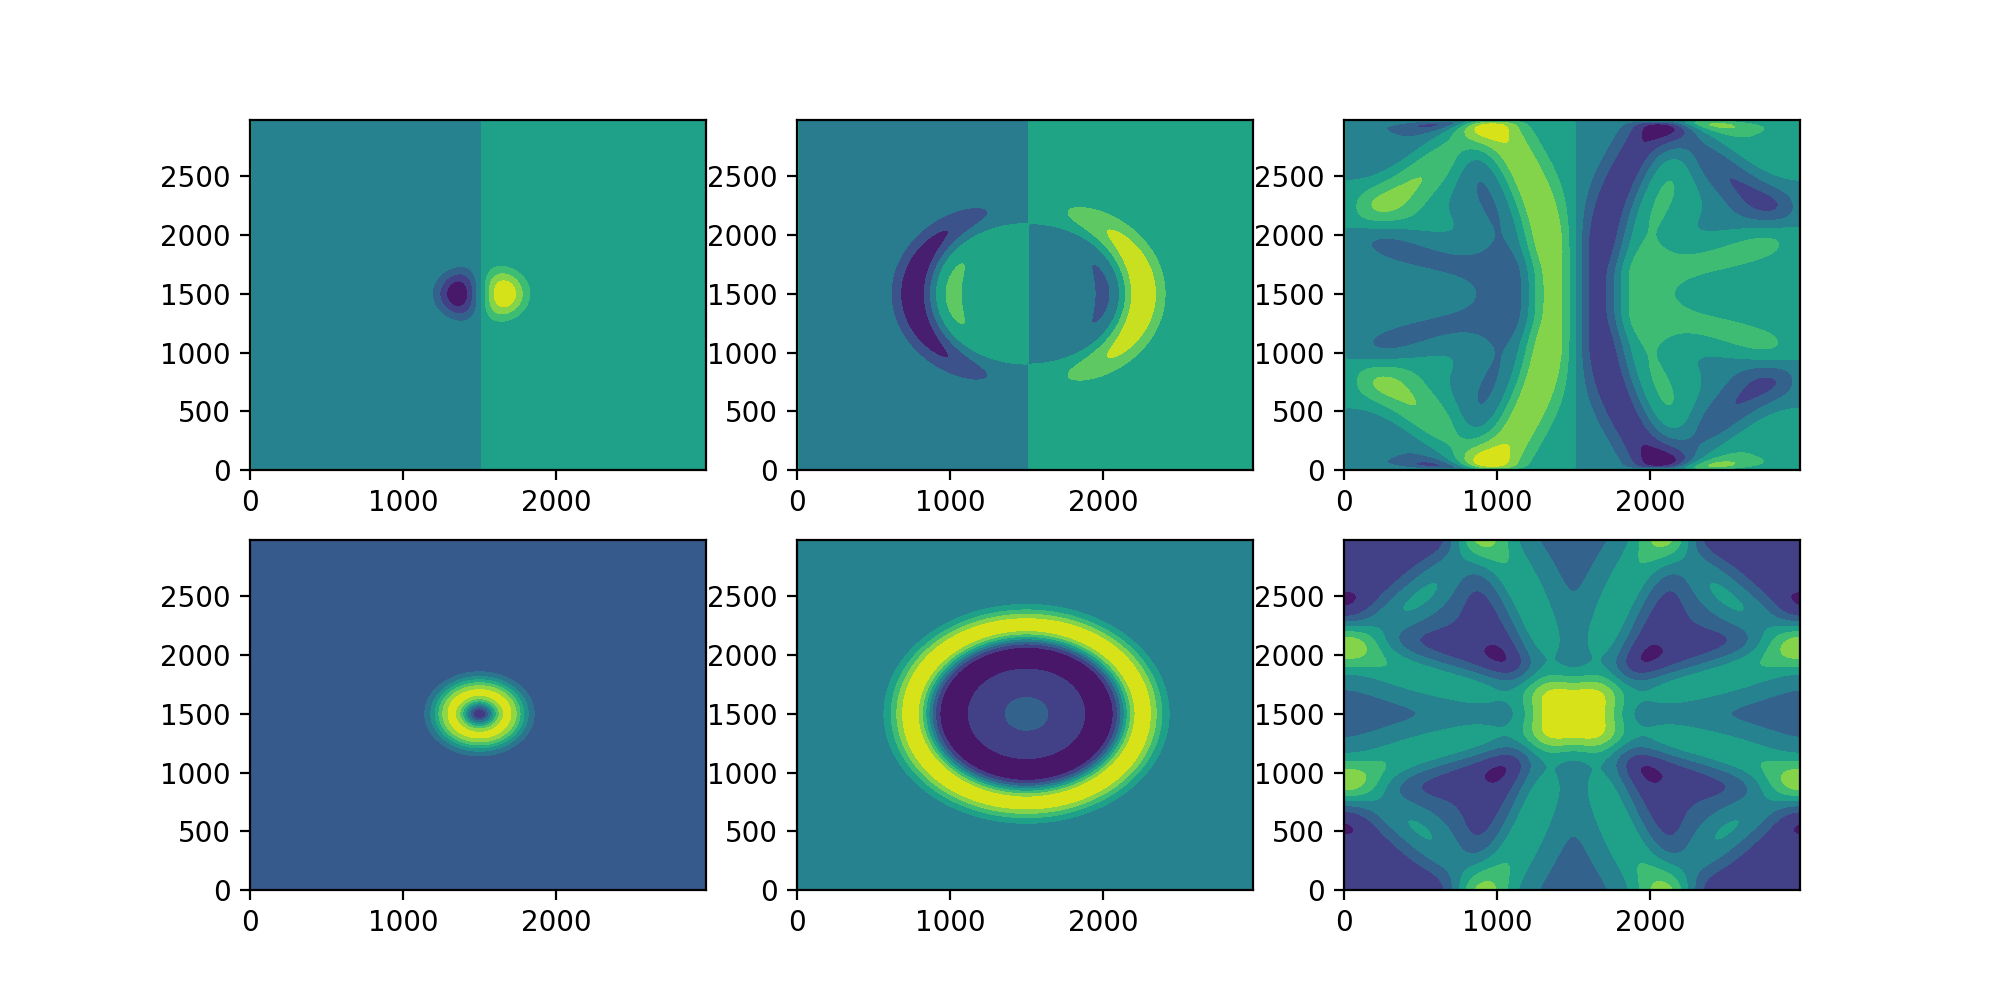

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(2, 3)
xpos=0
ypos=0

for time_step in range(1,int(n_timesteps)):
    time = time_step*Dt
    
    # Uncentered/forward time - Centered space
    # Here we assume that points are aranged as h_{j-1} - u_{j} - h_{j} - u_{j+1} etc.
    
    if Nonlinear=="True": # use non-linear advection terms
        uv = 0.5*( np.roll((u[:,:,time_step-1]),1,1) + u[:,:,time_step-1] 
                 ) * 0.5 * ( np.roll((v[:,:,time_step-1]),1,0) + v[:,:,time_step-1] )
        uh = 0.5*( np.roll((u[:,:,time_step-1]),-1,0) + u[:,:,time_step-1] ) * (h[:,:,time_step-1] + h_s)
        vh = 0.5*( np.roll((v[:,:,time_step-1]),-1,1) + v[:,:,time_step-1] ) * (h[:,:,time_step-1] + h_s)
        u2 = u[:,:,time_step-1]**2
        v2 = v[:,:,time_step-1]**2
        u[:,:,time_step] = u[:,:,time_step-1] 
        u[:,:,time_step] += - (Dt/(2*Dx))*(np.roll(u2,-1,0) - np.roll(u2,1,0))
        u[:,:,time_step] += - (Dt/Dy)*(np.roll(uv,-1,1) - uv)
        u[:,:,time_step] += - (g*Dt/Dx)*(h[:,:,time_step-1] - np.roll(h[:,:,time_step-1],1,0))
        
        v[:,:,time_step] = v[:,:,time_step-1] 
        v[:,:,time_step] += - (Dt/(2*Dy))*(np.roll(v2,-1,1) - np.roll(v2,1,1))
        v[:,:,time_step] += - (Dt/Dx)*(np.roll(uv,-1,0) - uv)
        v[:,:,time_step] += - (g*Dt/Dy)*(h[:,:,time_step-1] - np.roll(h[:,:,time_step-1],1,1))
        
        h[:,:,time_step] = h[:,:,time_step-1] 
        h[:,:,time_step] += - (Dt/(2*Dx))*(np.roll(uh,-1,0) - np.roll(uh,1,0))
        h[:,:,time_step] += - (Dt/(2*Dy))*(np.roll(vh,-1,0) - np.roll(vh,1,0))
        
    else:
        u[:,:,time_step] = u[:,:,time_step-1] 
        u[:,:,time_step] += - (U*Dt/(2*Dx))*(np.roll(u[:,:,time_step-1],-1,0) - \
                                                         np.roll(u[:,:,time_step-1],1,0))
        u[:,:,time_step] += - (V*Dt/(2*Dy))*(np.roll(u[:,:,time_step-1],-1,1) - \
                                                         np.roll(u[:,:,time_step-1],1,1))
        u[:,:,time_step] += - (g*Dt/Dx)*(h[:,:,time_step-1] - \
                                                         np.roll(h[:,:,time_step-1],1,0))
        
        h[:,:,time_step] = h[:,:,time_step-1] 
        h[:,:,time_step] += - (U*Dt/(2*Dx))*( np.roll( (h[:,:,time_step-1]-h_s) ,-1,0) - \
                                                         np.roll( (h[:,:,time_step-1]-h_s) ,1,0))
        h[:,:,time_step] += - (V*Dt/(2*Dy))*( np.roll( (h[:,:,time_step-1]-h_s) ,-1,1) - \
                                                         np.roll( (h[:,:,time_step-1]-h_s) ,1,1))
        h[:,:,time_step] += - (H*Dt/Dx)*(np.roll(u[:,:,time_step-1],-1,0) - \
                                                         u[:,:,time_step-1])
        h[:,:,time_step] += - (H*Dt/Dy)*(np.roll(v[:,:,time_step-1],-1,1) - \
                                                         v[:,:,time_step-1])
        
        v[:,:,time_step] = v[:,:,time_step-1] 
        v[:,:,time_step] += - (U*Dt/(2*Dx))*(np.roll(v[:,:,time_step-1],-1,0) - \
                                                        np.roll(v[:,:,time_step-1],1,0))
        v[:,:,time_step] += - (V*Dt/(2*Dy))*(np.roll(v[:,:,time_step-1],-1,1) - \
                                                         np.roll(v[:,:,time_step-1],1,1))
        v[:,:,time_step] += - (g*Dt/Dy)*(h[:,:,time_step-1] - \
                                                         np.roll(h[:,:,time_step-1],1,1))
        
    if Diffusivity=="True": # Add diffusivity terms
        # x-derivatives
        u[:,:,time_step] += (K*Dt/(Dx**2))*(np.roll(u[:,:,time_step-1],-1,0) - 2*u[:,:,time_step-1] \
                                         + np.roll(u[:,:,time_step-1],1,0))
        v[:,:,time_step] += (K*Dt/(Dx**2))*(np.roll(v[:,:,time_step-1],-1,0) - 2*v[:,:,time_step-1] \
                                         + np.roll(v[:,:,time_step-1],1,0))
        h[:,:,time_step] += (K*Dt/(Dx**2))*(np.roll(h[:,:,time_step-1],-1,0) - 2*h[:,:,time_step-1] \
                                         + np.roll(h[:,:,time_step-1],1,0))
        # y-derivatives
        u[:,:,time_step] += (K*Dt/(Dy**2))*(np.roll(u[:,:,time_step-1],-1,1) - 2*u[:,:,time_step-1] \
                                         + np.roll(u[:,:,time_step-1],1,1))
        v[:,:,time_step] += (K*Dt/(Dy**2))*(np.roll(v[:,:,time_step-1],-1,1) - 2*v[:,:,time_step-1] \
                                         + np.roll(v[:,:,time_step-1],1,1))
        h[:,:,time_step] += (K*Dt/(Dy**2))*(np.roll(h[:,:,time_step-1],-1,1) - 2*h[:,:,time_step-1] \
                                         + np.roll(h[:,:,time_step-1],1,1))
    if Coriolis=="True": # Add Coriolis terms
        # x-derivatives
        u_on_v = 0.25*(u[:,:,time_step-1] + np.roll(u[:,:,time_step-1],-1,0) +
                 np.roll(u[:,:,time_step-1],1,1) + np.roll(u[:,:,time_step-1],(-1,1),(0,1)))
        v_on_u = 0.25*(v[:,:,time_step-1] + np.roll(v[:,:,time_step-1],1,0) +
                 np.roll(v[:,:,time_step-1],-1,1) + np.roll(v[:,:,time_step-1],(1,-1),(0,1)))
        u[:,:,time_step] += Dt*coriolis_parameter*v_on_u
        v[:,:,time_step] += - Dt*coriolis_parameter*u_on_v
        
    if Restoring == "True": # restore to original surface height field
         h[:,:,time_step] += Dt*restoring_rate*(h[:,:,0]- h[:,:,time_step])
            
    if Boundary_Condition == "Coasts": # Set normal velocities to zero at boundaries
        u[:,0,time_step]=0
        u[:,-1,time_step]=0
            
        
    if (time==20) or (time==100) or (time==400):
        if plot_type=="Line":
            axs[ypos,xpos].plot(x, u[:,0,time_step],'k-',label="Numerical u at t={}".format(time))
            axs[ypos,xpos].plot(x, u[:,0,0],'k:',label="Initial u".format(time))
            ypos=ypos+1
            axs[ypos,xpos].plot(x, h[:,0,time_step],'k-',label="Numerical h at t={}".format(time))
            axs[ypos,xpos].plot(x, h[:,0,0],'k:',label="Initial h".format(time))
            xpos = xpos+1
            ypos=ypos-1
        elif plot_type=="Contour":
            axs[ypos,xpos].contourf(x, y, u[:,:,time_step])
            #axs[ypos,xpos].colorbar()
            ypos=ypos+1
            axs[ypos,xpos].contourf(x, y, h[:,:,time_step])
            xpos = xpos+1
            ypos=ypos-1
        
        
plt.show()

In [3]:
# plt.rcParams['figure.figsize'] = [5, 2.5]
# fig, ax = plt.subplots()


# line, = ax.plot(x[:,0], u[:,int(Ny/2),0])

# def animate(i):
#     line.set_ydata(u[:,int(Ny/2),i])  # update the data.
#     return line,

# ani = animation.FuncAnimation(
#     fig, animate, frames=2000, interval=1, save_count=200)
# plt.show()

In [4]:
# plt.rcParams['figure.figsize'] = [5, 2.5]
# fig, ax = plt.subplots()

# def animate(i):
#        ax.clear()
#        ax.contourf(h[:,:,i], vmax=H+np.max(abs(h-H)), vmin=H-np.max(abs(h-H)), cmap='seismic')
#        ax.set_title('%03d'%(i))

# interval = 1#in seconds     
# ani = animation.FuncAnimation(fig,animate,400,interval=interval,blit=False)

# plt.show()

In [5]:
# plt.rcParams['figure.figsize'] = [5, 2.5]
# fig, ax = plt.subplots()
# plt.contourf(x, y, h[:,:,-1], vmax=H+np.max(abs(h-H)), vmin=H-np.max(abs(h-H)), cmap='seismic')
            
# plt.colorbar()
# plt.show

In [6]:
# plt.rcParams['figure.figsize'] = [5, 2.5]
# fig, ax = plt.subplots()
# plt.contourf(x, y, u[:,:,-1], vmax=U+np.max(abs(u-U)), vmin=U-np.max(abs(u-U)), cmap='seismic')
            
# plt.colorbar()
# plt.show

In [7]:
# plt.rcParams['figure.figsize'] = [5, 2.5]
# fig, ax = plt.subplots()
# plt.contourf(x, y, v[:,:,-100], vmax=V+np.max(abs(v-V)), vmin=V-np.max(abs(v-V)), cmap='seismic')
            
# plt.colorbar()
# plt.show

In [8]:
# plt.rcParams['figure.figsize'] = [5, 2.5]
# fig, ax = plt.subplots()
# # plt.streamplot(y[0,:],x[:,0], v[:,:,-1], u[:,:,-1])
# plt.streamplot(x[:,0],y[0,:], np.transpose(u[:,:,-1]), np.transpose(v[:,:,-1]))         
# plt.show

In [9]:
# plt.rcParams['figure.figsize'] = [5, 2.5]
# fig, ax = plt.subplots()
# if topography == "Water_Pile" or topography == "Water_Ridge":
#     plt.pcolor(x,y,h[:,:,0])
# else:
#     plt.pcolor(x,y,h_s[:,:])
# plt.colorbar()
# plt.show

<IPython.core.display.Javascript object>


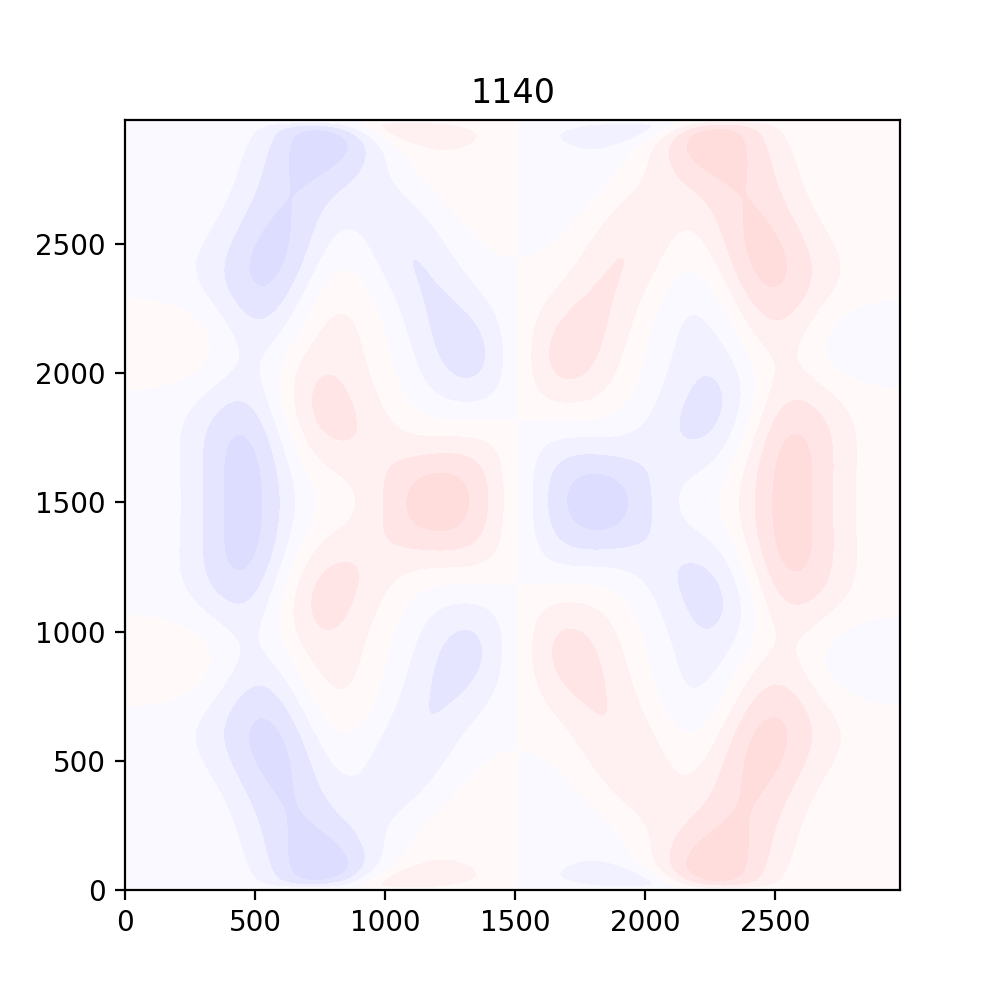

In [10]:
plt.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()

def animate(i):
       ax.clear()
       #ax.contourf(u[:,:,i*10], vmax=U+np.max(abs(u[:,:,i*10]-U)), vmin=U-np.max(abs(u[:,:,i*10]-U)), cmap='seismic')
       ax.contourf(x,y,u[:,:,i*30], vmax=.2, vmin=-.2, cmap='seismic')
       ax.set_title('%03d'%(i*30))

interval = 1#in seconds     
ani = animation.FuncAnimation(fig,animate,40,interval=interval+1e3,blit=False)

plt.show()